In [1]:
import sys
sys.path.append('../../../')

In [2]:
from win10toast import ToastNotifier
toast = ToastNotifier()

In [3]:
import torch
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import numpy as np
from tqdm.auto import tqdm, trange

from models.train_reg import train, test
from models.models import GCN, GAT, GraphSAGE, FNN
from models.utils import ContagionDataset, set_seed
from sklearn.metrics import matthews_corrcoef, mean_squared_error, mean_absolute_error

Using backend: pytorch


In [4]:
def pretty(ld, indent=0):
    with open('result.txt', 'w', encoding='utf-8') as file:
        for d in tqdm(ld):
            file.write('{' + '\n')
            for key, value in d.items():
                file.write('\t' * (indent+1) + str(key) + ':' + str(value) + '\n')
                # file.write('\t' * (indent+1) + str(key) + '\n')
                # file.write('\t' * (indent+2) + str(value) + '\n')
            file.write('},\n')

In [5]:
do_train = False

seed = 4444
set_seed(seed)

metric_filter_1 = 'val_rmse_perc'
metric_filter_2 = 'test_rmse_perc'

data_dir = '../data'
log_path = './logs'
save_path = './saved'

# Big dataset: Additional stress

In [6]:
sets_lengths = (0.5, 0.25, 0.25)
target = 'additional_stress'

dataset = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    target = target,
)

out_feats = 1

## Baseline

### FNN

In [7]:
save_model = f'{save_path}_fnn'
log_dir = f'{log_path}_fnn'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = False,
    target = target,
)

# fnn_model = dict(
#     in_features=[len(dataset_val.node_attributes)],
#     h_features=[[5, 10], [10, 15], [5,5,5], [5, 10, 15], [5, 10, 15, 20], [5], [10], [15]],
#     out_features=[dataset_val.num_classes],
#     activation=[torch.nn.ReLU()],
#     norm_nodes = [None, 'bn', 'gn'],
#     dropout=[0.2, 0.5, 0.0],
#     # other
#     lr=[1, 1e-1, 1e-2],
#     label_smoothing=[0.0, 0.2, 0.4],
# )

fnn_model = dict(
    in_features=[len(dataset_val.node_attributes)],
    h_features=[[100], [100] * 2, [100] * 3, [200], [200]*2,[200]*3,[500],[500]*2,[500]*3],
    out_features=[dataset_val.num_classes],
    activation=[torch.nn.ReLU()],
    norm_nodes = [None, 'bn', 'gn'],
    dropout=[0.2, 0.0],
    # other
    lr=[1e-1],
)
list_model = [dict(zip(fnn_model.keys(), k)) for k in itertools.product(*fnn_model.values())]

In [8]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')

        train(
            model=FNN(**d),
            dict_model=d,
            dataset_train=dataset_val,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=200,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=False,
            loss_type='mse',
            scheduler_patience=20,
        )

#### Results

In [9]:
res_edges_fnn = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=False,
)

100%|██████████| 1134/1134 [00:49<00:00, 23.06it/s]


In [10]:
res_edges = res_edges_fnn
res_edges[0]

{'in_features': 4,
 'h_features': [100, 100, 100],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'gn',
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 20,
 'train_self_loop': False,
 'train_drop_edges': 0,
 'train_loss': 0.52224106,
 'train_acc': 0.5664820075035095,
 'val_acc': 0.5955678820610046,
 'epoch': 70,
 'model_class': 'fnn',
 'path_name': '4_[100_100_100]_4_ReLU()_gn_0.0_0.1_adamw_max_val_mcc_False_mse_20_False_0_70',
 'train_rmse': 0.8093977104857736,
 'val_rmse': 0.871207650381413,
 'test_rmse': 0.902443589446434,
 'train_rmse_perc': 0.18841816,
 'val_rmse_perc': 0.210497,
 'test_rmse_perc': 0.21672384,
 'train_mcc': 0.42365982598505986,
 'val_mcc': 0.4587277287084364,
 'test_mcc': 0.4701168731181468,
 'test_acc': 0.6011080145835876,
 'train_mae_perc': 0.14172983,
 'val_mae_perc': 0.14950538,
 'test_mae_perc': 0.156

In [11]:
all = res_edges[2]
# ascending order
# sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])[::-1]
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [200, 200, 200],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'gn',
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 20,
 'train_self_loop': False,
 'train_drop_edges': 0,
 'train_loss': 0.5242067,
 'train_acc': 0.5526315569877625,
 'val_acc': 0.5761772990226746,
 'epoch': 50,
 'model_class': 'fnn',
 'path_name': '4_[200_200_200]_4_ReLU()_gn_0.0_0.1_adamw_max_val_mcc_False_mse_20_False_0_50',
 'train_rmse': 0.7824246709115004,
 'val_rmse': 0.8033861853933552,
 'test_rmse': 0.8775437895017404,
 'train_rmse_perc': 0.18568407,
 'val_rmse_perc': 0.20138322,
 'test_rmse_perc': 0.21386151,
 'train_mcc': 0.40466245762288594,
 'val_mcc': 0.43523280336940584,
 'test_mcc': 0.44730081151914064,
 'test_acc': 0.5844875574111938,
 'train_mae_perc': 0.14490394,
 'val_mae_perc': 0.15085214,
 'test_mae_perc': 

In [12]:
all = res_edges[2]
# ascending order
# sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])[::-1]
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [200, 200, 200],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'gn',
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 20,
 'train_self_loop': False,
 'train_drop_edges': 0,
 'train_loss': 0.5242067,
 'train_acc': 0.5526315569877625,
 'val_acc': 0.5761772990226746,
 'epoch': 50,
 'model_class': 'fnn',
 'path_name': '4_[200_200_200]_4_ReLU()_gn_0.0_0.1_adamw_max_val_mcc_False_mse_20_False_0_50',
 'train_rmse': 0.7824246709115004,
 'val_rmse': 0.8033861853933552,
 'test_rmse': 0.8775437895017404,
 'train_rmse_perc': 0.18568407,
 'val_rmse_perc': 0.20138322,
 'test_rmse_perc': 0.21386151,
 'train_mcc': 0.40466245762288594,
 'val_mcc': 0.43523280336940584,
 'test_mcc': 0.44730081151914064,
 'test_acc': 0.5844875574111938,
 'train_mae_perc': 0.14490394,
 'val_mae_perc': 0.15085214,
 'test_mae_perc': 

In [13]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 1134/1134 [00:00<00:00, 29922.18it/s]


In [14]:
cm = all[sort_idx[0]]['test_cm'][0]

In [15]:
(cm.labels==0).sum()

tensor(87)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\systemic-risk-predictor\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

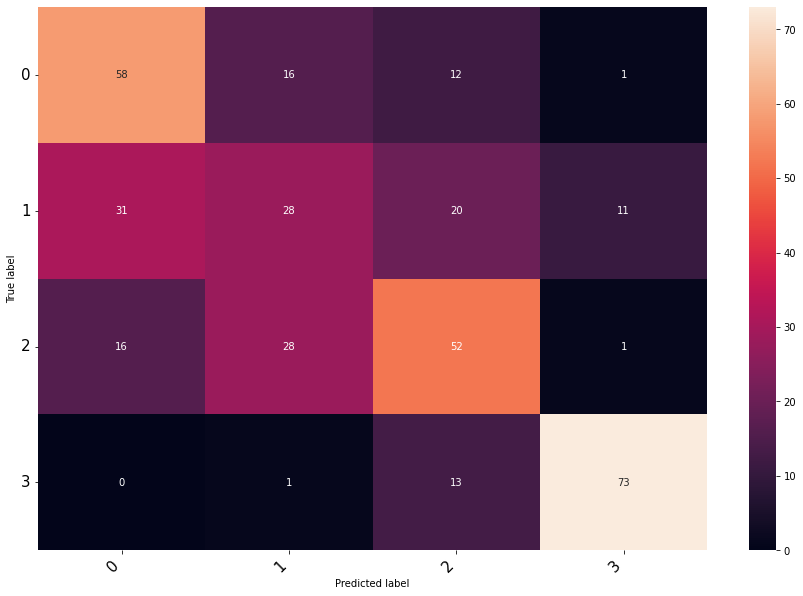

In [16]:
cm.visualize()

In [17]:
cm.class_accuracy

tensor([0.6667, 0.3111, 0.5361, 0.8391])

In [18]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.22027716, 0.2573076, 0.23426802, 0.10760685]

In [19]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k]) for k in range(0, cm.size)]

[0.14896408, 0.21729448, 0.17851594, 0.094419084]

### GCN

In [ ]:
save_model = f'{save_path}_gcn'
log_dir = f'{log_path}_gcn'

add_self_loop = True

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = add_self_loop,
    target = target,
)

gcn_model = dict(
    in_features=[len(dataset_val.node_attributes)],
    h_features=[[15] * 3, [10, 15, 20], [5, 10, 15, 20],],
    out_features=[dataset_val.num_classes],
    activation=[torch.nn.ReLU()],
    norm_edges=['both', 'none'],
    norm_nodes=[None, 'bn', 'gn'],
    dropout=[0.2, 0.0],
    # other
    lr=[1e-1],
    use_edge_weight=[True,],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(gcn_model.keys(), k)) for k in itertools.product(*gcn_model.values())]

# gcn_model = dict(
#     in_features=[len(dataset_val.node_attributes)],
#     h_features=[[10] * 3],
#     out_features=[dataset_val.num_classes],
#     activation=[torch.nn.ReLU()],
#     norm_edges=['both', 'none'],
#     norm_nodes=[None, 'bn', 'gn'],
#     dropout=[0.2, 0.0],
#     # other
#     lr=[1],
#     label_smoothing=[0.0,],
#     use_edge_weight=[True, ],
#     drop_edges=[0,0.2],
# )
# list_model = [{i:j[k] for i,j in gcn_model.items()} for k in range(len(gcn_model['in_features']))]

In [ ]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        # dataset_valid = ContagionDataset(
        #     raw_dir=data_dir,
        #     drop_edges=0,
        #     sets_lengths=sets_lengths,
        #     add_self_loop = add_self_loop,
        #     target = target,
        #     seed=seed,
        # )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GCN(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
        )

#### Results

In [ ]:
res_edges_gcn = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

In [ ]:
res_edges = res_edges_gcn
res_edges[0]

In [ ]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])[::-1]
all[sort_idx[0]]['dict']

In [ ]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])[::-1]
all[sort_idx[0]]['dict']

In [ ]:
pretty([all[k]['dict'] for k in sort_idx])

### GraphSAGE

In [20]:
save_model = f'{save_path}_sage'
log_dir = f'{log_path}_sage'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = True,
    target = target,
)

# sage_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     h_features = [[20] * 3, [25] * 3, [15] * 3, [10], [20,25,20], [30] * 3], 
#     out_features = [out_feats],
#     aggregator_type = ['lstm'],
#     norm_edges = ['right', 'none'],
#     norm_nodes = [None, 'bn', 'gn'],
#     activation = [torch.nn.ReLU()],
#     feat_drop = [0.2, 0],
#     # other
#     lr=[1e-2],
#     use_edge_weight=[True],
#     add_self_loop=[True],
#     drop_edges=[0,0.2],
# )
# list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]

sage_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[500]*2], 
    out_features = [out_feats],
    aggregator_type = ['lstm'],
    norm_edges = ['none'],
    norm_nodes = ['gn'],
    activation = [torch.nn.ReLU()],
    feat_drop = [0, 0.2],
    # other
    lr=[1e-2],
    use_edge_weight=[True],
    add_self_loop=[True],
    drop_edges=[0, 0.2],
)
list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]
# list_model = [{i:j[k] for i,j in sage_model.items()} for k in range(len(sage_model['in_features']))]

In [21]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        add_self_loop = d.pop('add_self_loop')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        dataset_valid = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=0,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GraphSAGE(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_valid,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=2000,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=50,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
            scheduler_patience=300,
        )

#### Results

In [22]:
res_edges_sage = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

toast.show_toast("Done")

100%|██████████| 197/197 [00:53<00:00,  3.70it/s]


True

In [23]:
res_edges = res_edges_sage
res_edges[0]

{'in_features': 4,
 'h_features': [500, 500],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 300,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 0.22543687,
 'train_acc': 0.8157894611358643,
 'val_acc': 0.7119113802909851,
 'epoch': 1250,
 'model_class': 'sage',
 'path_name': '4_[500_500]_1_lstm_none_gn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_300_True_0.2_1250',
 'train_rmse': 0.4794965041654894,
 'val_rmse': 0.713929471907923,
 'test_rmse': 0.7330730672202168,
 'train_rmse_perc': 0.12888168,
 'val_rmse_perc': 0.19355662,
 'test_rmse_perc': 0.1867163,
 'train_mcc': 0.7552885327459816,
 'val_mcc': 0.6138580822578542,
 'test_mcc': 0.5738211962655886,
 'test_acc': 0.678670346736908,
 'train_mae_perc': 0.094

In [24]:
all = res_edges[2]
# ascending order
# sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])[::-1]
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [500, 500],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 300,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 0.26347888,
 'train_acc': 0.761772871017456,
 'val_acc': 0.6897506713867188,
 'epoch': 1200,
 'model_class': 'sage',
 'path_name': '4_[500_500]_1_lstm_none_gn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_300_True_0.2_1200',
 'train_rmse': 0.5328541245083313,
 'val_rmse': 0.7021928454803333,
 'test_rmse': 0.7627040392731284,
 'train_rmse_perc': 0.13400543,
 'val_rmse_perc': 0.1808477,
 'test_rmse_perc': 0.18783118,
 'train_mcc': 0.6827911135154195,
 'val_mcc': 0.5851702619107766,
 'test_mcc': 0.5057727339273372,
 'test_acc': 0.628808856010437,
 'train_mae_perc': 0.101

In [25]:
all = res_edges[2]
# ascending order
# sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])[::-1]
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [500, 500],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 300,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 0.26347888,
 'train_acc': 0.761772871017456,
 'val_acc': 0.6897506713867188,
 'epoch': 1200,
 'model_class': 'sage',
 'path_name': '4_[500_500]_1_lstm_none_gn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_300_True_0.2_1200',
 'train_rmse': 0.5328541245083313,
 'val_rmse': 0.7021928454803333,
 'test_rmse': 0.7627040392731284,
 'train_rmse_perc': 0.13400543,
 'val_rmse_perc': 0.1808477,
 'test_rmse_perc': 0.18783118,
 'train_mcc': 0.6827911135154195,
 'val_mcc': 0.5851702619107766,
 'test_mcc': 0.5057727339273372,
 'test_acc': 0.628808856010437,
 'train_mae_perc': 0.101

In [26]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 197/197 [00:00<00:00, 24693.76it/s]


#### cm

In [27]:
cm = all[sort_idx[0]]['test_cm'][0]

In [28]:
(cm.labels==0).sum()

tensor(87)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\systemic-risk-predictor\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

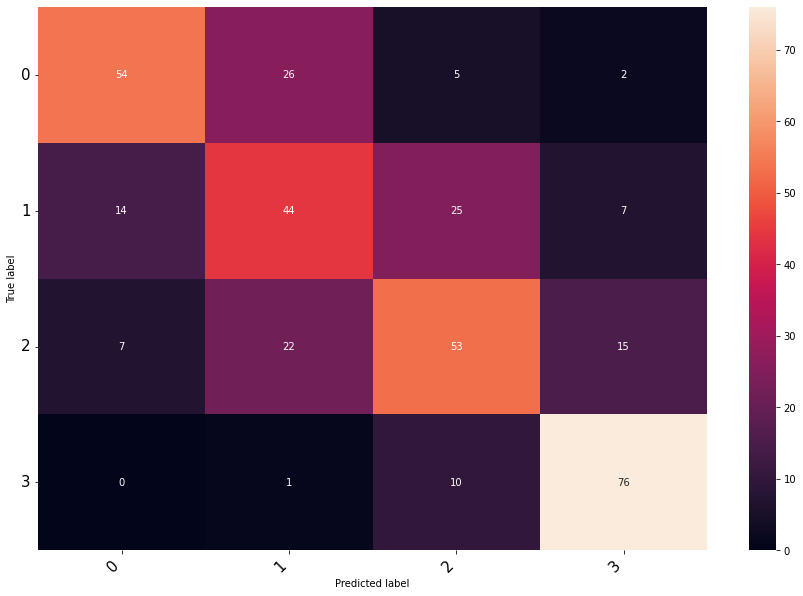

In [29]:
cm.visualize()

In [30]:
cm.class_accuracy

tensor([0.6207, 0.4889, 0.5464, 0.8736])

In [31]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.20299768, 0.21330707, 0.19751848, 0.120909944]

In [32]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k]) for k in range(0, cm.size)]

[0.12516887, 0.1655161, 0.14869633, 0.0947695]

#### GraphSAGE Base_n

In [33]:
save_model = f'{save_path}_sage_base'
log_dir = f'{log_path}_sage_base'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = True,
    target = target,
)

# sage_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     h_features = [[20] * 3, [25] * 3, [15] * 3, [10], [20,25,20], [30] * 3], 
#     out_features = [out_feats],
#     aggregator_type = ['lstm'],
#     norm_edges = ['right', 'none'],
#     norm_nodes = [None, 'bn', 'gn'],
#     activation = [torch.nn.ReLU()],
#     feat_drop = [0.2, 0],
#     # other
#     lr=[1e-2],
#     use_edge_weight=[True],
#     add_self_loop=[True],
#     drop_edges=[0,0.2],
# )
# list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]

sage_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[500]*2], 
    out_features = [out_feats],
    aggregator_type = ['lstm'],
    norm_edges = ['none'],
    norm_nodes = ['gn'],
    activation = [torch.nn.ReLU()],
    feat_drop = [0, 0.2],
    # other
    lr=[1e-2],
    use_edge_weight=[True],
    add_self_loop=[True],
    drop_edges=[0, 0.2],
)
list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]
# list_model = [{i:j[k] for i,j in sage_model.items()} for k in range(len(sage_model['in_features']))]

In [34]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        add_self_loop = d.pop('add_self_loop')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        dataset_valid = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=0,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GraphSAGE(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_valid,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=2000,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=50,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
            scheduler_patience=300,
            base_n=True,
        )

##### Results

In [35]:
res_edges_sage_base = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
    base_n=True,
)

toast.show_toast("Done")

100%|██████████| 164/164 [00:40<00:00,  4.03it/s]


True

In [36]:
res_edges = res_edges_sage_base
res_edges[0]

{'in_features': 4,
 'h_features': [500, 500],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 300,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 0.19805254,
 'train_acc': 0.5512465238571167,
 'val_acc': 0.5263158082962036,
 'epoch': 1950,
 'model_class': 'sage',
 'path_name': '4_[500_500]_1_lstm_none_gn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_300_True_0.2_1950',
 'train_rmse': 0.7061267297367757,
 'val_rmse': 0.8421052631578947,
 'test_rmse': 0.9009075141380889,
 'train_rmse_perc': 0.16005154,
 'val_rmse_perc': 0.21330929,
 'test_rmse_perc': 0.23341702,
 'train_mcc': 0.4114926902679057,
 'val_mcc': 0.38095856892275876,
 'test_mcc': 0.3707744297396156,
 'test_acc': 0.5207756161689758,
 'train_mae_perc': 0

In [37]:
all = res_edges[2]
# ascending order
# sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])[::-1]
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [500, 500],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 300,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 0.24700959,
 'train_acc': 0.5789473652839661,
 'val_acc': 0.5567867159843445,
 'epoch': 1000,
 'model_class': 'sage',
 'path_name': '4_[500_500]_1_lstm_none_gn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_300_True_0.2_1000',
 'train_rmse': 0.6982367979695578,
 'val_rmse': 0.7999307449247718,
 'test_rmse': 0.8993688152965823,
 'train_rmse_perc': 0.1695676,
 'val_rmse_perc': 0.20585331,
 'test_rmse_perc': 0.2219151,
 'train_mcc': 0.4480356820511895,
 'val_mcc': 0.42027058658642047,
 'test_mcc': 0.31011994586530356,
 'test_acc': 0.4764542877674103,
 'train_mae_perc': 0.

In [38]:
all = res_edges[2]
# ascending order
# sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])[::-1]
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [500, 500],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 300,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 0.24700959,
 'train_acc': 0.5789473652839661,
 'val_acc': 0.5567867159843445,
 'epoch': 1000,
 'model_class': 'sage',
 'path_name': '4_[500_500]_1_lstm_none_gn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_300_True_0.2_1000',
 'train_rmse': 0.6982367979695578,
 'val_rmse': 0.7999307449247718,
 'test_rmse': 0.8993688152965823,
 'train_rmse_perc': 0.1695676,
 'val_rmse_perc': 0.20585331,
 'test_rmse_perc': 0.2219151,
 'train_mcc': 0.4480356820511895,
 'val_mcc': 0.42027058658642047,
 'test_mcc': 0.31011994586530356,
 'test_acc': 0.4764542877674103,
 'train_mae_perc': 0.

In [39]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 164/164 [00:00<00:00, 27484.95it/s]


##### cm

In [40]:
cm = all[sort_idx[0]]['test_cm'][0]

In [41]:
(cm.labels==0).sum()

tensor(87)

In [42]:
cm.pseudo_perc.max()

tensor(0.9999)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\systemic-risk-predictor\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

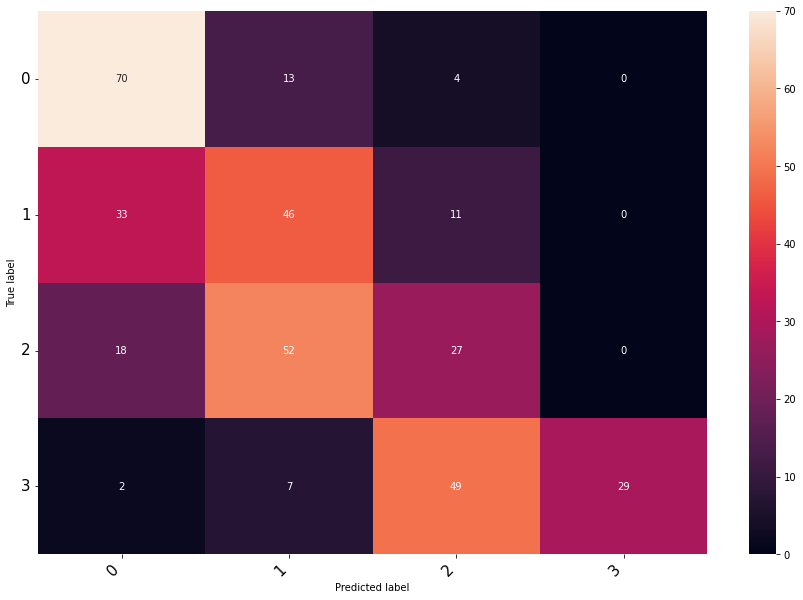

In [43]:
cm.visualize()

In [44]:
cm.class_accuracy

tensor([0.8046, 0.5111, 0.2784, 0.3333])

In [45]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.14739202, 0.17924361, 0.28343323, 0.24457124]

In [46]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k]) for k in range(0, cm.size)]

[0.08948336, 0.14880647, 0.24371256, 0.20451345]

### GAT

In [47]:
save_model = f'{save_path}_gat'
log_dir = f'{log_path}_gat'

add_self_loop = True

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = add_self_loop,
    target = target,
)

gat_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[10], [10] * 2, [15], [15] * 2, [20], [20] * 2, [25], [25] * 2],
    out_features = [out_feats],
    num_heads = [[4] * 2, [2] * 2, [4, 2]],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    negative_slope = [0.2, 0.4],
    feat_drop = [0.2],
    attn_drop = [0.2],
    residual = [True],
    # other
    lr=[1e-2,],
    use_edge_weight=[False],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(gat_model.keys(), k)) for k in itertools.product(*gat_model.values())]

# gat_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     # h_features = [[10], [15], [20]], 
#     h_features = [[10] * 3, [15] * 3, [20] * 3], 
#     out_features = [out_feats],
#     # num_heads = [[4] * 4],
#     num_heads = [[4, 2, 2]],
#     norm_nodes = [None, 'bn', 'gn'],
#     activation = [torch.nn.ReLU()],
#     negative_slope = [0.2, 0.3, 0.4],
#     feat_drop = [0.2],
#     attn_drop = [0.2],
#     residual = [True],
#     # other
#     lr=[1e-2,],
#     label_smoothing=[0.0],
#     use_edge_weight=[False],
#     drop_edges=[0,],
# )
# list_model = [dict(zip(gat_model.keys(), k)) for k in itertools.product(*gat_model.values())]
# list_model = [{i:j[k] for i,j in gat_model.items()} for k in range(len(gat_model['in_features']))]

In [48]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        # dataset_valid = ContagionDataset(
        #     raw_dir=data_dir,
        #     drop_edges=0,
        #     sets_lengths=sets_lengths,
        #     add_self_loop = add_self_loop,
        #     target = target,
        #     seed=seed,
        # )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GAT(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
        )

#### Results

In [49]:
res_edges_gat = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=False,
)

0it [00:00, ?it/s]


In [50]:
res_edges = res_edges_gat
res_edges[0]

In [51]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])[::-1]
all[sort_idx[0]]['dict']

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])[::-1]
all[sort_idx[0]]['dict']

In [ ]:
pretty([all[k]['dict'] for k in sort_idx])